In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import json, requests
from datetime import datetime
from itertools import zip_longest

%matplotlib inline

In [2]:
# helper functions 

# moving average function
def ma(x,n):
    cs = list(np.cumsum(x))
    return [ (x-y)/n for (x,y) in zip(cs, [0]*n + cs[:-n])]

# group a list into sublists of length n
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

# Return a list of ratios between successive numbers in a list
def ratio(d):
    return [x/y for (x,y) in zip(d[1:],d[:-1])] 
    # return([1 if y == 0 else x/y for (x,y) in zip(d[1:],d[:-1])])
    # return [1]*n + [1 if y == 0 else x/y for (x,y) in zip(d[n:],d[:-n])]
    
def toDateTime(strDate):
    return datetime(*[int(x) for x in strDate.split('-')])

def get_weeklydeaths(deaths):
    # group the deaths into chunks 7 days long, pad at the end with the average of last 7 days number
    return list(map(sum,  grouper(deaths, 7, sum(deaths[-7:])/7)))
    
def r(weeklydeaths):  
    # week on week ratio of weekly deaths
    return ratio(weeklydeaths)

def getData(url, country):
    data = [x for x in requests.get(url=url).json()[country['field']] if x['areaCode'] == country['areaCode']]
    data.sort(key = lambda i: toDateTime(i['reportingDate']))
    r = json.dumps(data).replace('null', '0') # replace null with zero
    data = json.loads(r)
    return data

In [3]:
deathsJson = "https://coronavirus.data.gov.uk/downloads/json/coronavirus-deaths_latest.json"
casesJson = "https://coronavirus.data.gov.uk/downloads/json/coronavirus-cases_latest.json"

uk = {'field': 'overview', 'areaCode': 'K02000001'}
england = {'field': 'countries', 'areaCode': 'E92000001'}
northernIreland = {'field': 'countries', 'areaCode': 'N92000002'}
scotland = {'field': 'countries', 'areaCode': 'S92000003'}
wales = {'field': 'countries', 'areaCode': 'W92000004'}

In [4]:
startDate = toDateTime('2020-03-15') # get data from 2020-03-16, first day there were more than 60 cumulative deaths (1 in a million)
country = england # uk, england, scotland, northernIreland, wales

data = [x for x in getData(deathsJson, country) if toDateTime(x['reportingDate'])>startDate]

In [5]:
dailydeaths = [x['dailyChangeInDeaths'] for x in data]
smoothed_dailydeaths = list(ma(dailydeaths, 7))


print (dailydeaths[-21:-14],dailydeaths[-14:-7],dailydeaths[-7:])
print(sum(dailydeaths[-21:-14]),sum(dailydeaths[-14:-7]), sum(dailydeaths[-7:]))
print (sum(dailydeaths[-14:-7])/sum(dailydeaths[-21:-14]),sum(dailydeaths[-7:])/sum(dailydeaths[-14:-7]))

[417, 104, 117, 405, 384, 349, 194] [81, 96, 315, 328, 149, 343, 179] [65, 52, 277, 229, 133, 186, 171]
1970 1491 1113
0.7568527918781726 0.7464788732394366


In [6]:
weeklydeaths = get_weeklydeaths(dailydeaths)
rdata = r(weeklydeaths)
#rdata = r(smoothed_dailydeaths)
print(len(dailydeaths)//7, "Weeks and", len(dailydeaths)%7, "days")

print("Weeks after 60 deaths:", "R")
for rval in rdata:
    print("Week " + str(rdata.index(rval) + 1) + ":", rval)

12 Weeks and 6 days
Weeks after 60 deaths: R
Week 1: 5.864864864864865
Week 2: 2.963901689708141
Week 3: 1.5138636952578388
Week 4: 0.952413557001027
Week 5: 0.8826383896477354
Week 6: 0.7709224190592547
Week 7: 0.7762810353935552
Week 8: 0.8162640353861857
Week 9: 0.9241350562734473
Week 10: 0.7370320252593595
Week 11: 0.9026927784577723
Week 12: 0.8183050847457627


Text(0, 0.5, 'Deaths per day')

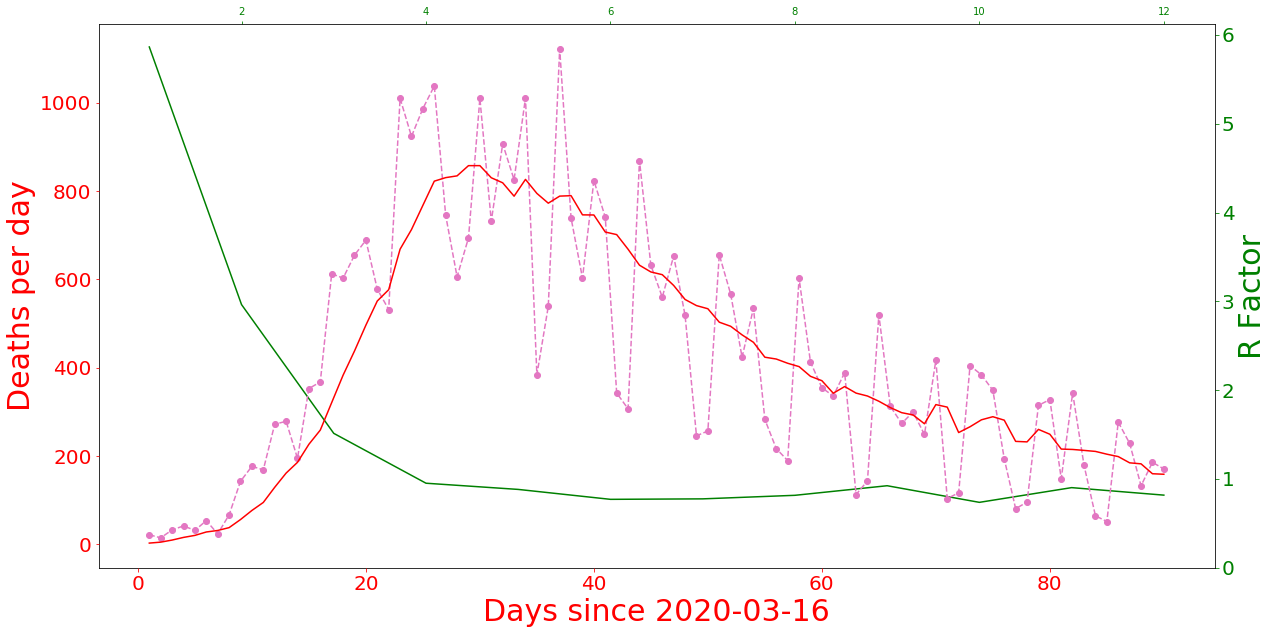

In [7]:
# Draw some pictures
rx = np.linspace(1, len(rdata), len(rdata))

# fig, ax1 = plt.subplots(1, figsize=(10, 8))

fig=plt.figure(figsize=(20, 10))

ax1=fig.add_subplot(111, label="1")
ax1.plot(rx,rdata,color="g")
ax1.tick_params(axis='x', colors="g")
ax1.tick_params(axis='y', colors="g",labelsize=20)
# ax1.set_xlabel(['Weeks since first death'], color="g",fontsize=30) 
ax1.set_ylabel('R Factor', color="g", fontsize=30)  
ax1.yaxis.set_label_position('right')
ax1.xaxis.tick_top()
ax1.yaxis.tick_right()
ax1.set_ylim(bottom=0)


x = np.linspace(1, len(dailydeaths), len(dailydeaths))
ax2=fig.add_subplot(111, frame_on=False, label="2")
ax2.plot(x, dailydeaths, 'o--k',color="C6")
ax2.plot(x, smoothed_dailydeaths,color="r")
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()
ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left') 
ax2.tick_params(axis='x', colors="r",labelsize=20)
ax2.tick_params(axis='y', colors="r", labelsize=20)
ax2.set_xlabel('Days since ' + data[0]['reportingDate'], color="r", fontsize=30) 
ax2.set_ylabel('Deaths per day', color="r", fontsize=30)       

In [8]:
rx = np.linspace(1, len(rdata), len(rdata))

# fig, ax1 = plt.subplots(1, figsize=(10, 8))

fig=plt.figure(figsize=(20, 10))

ax1=fig.add_subplot(111, label="1",)
ax1.plot(rx,rdata,color="g")
ax1.tick_params(axis='x', colors="g")
ax1.tick_params(axis='y', colors="g",labelsize=20)
ax1.set_ylabel('R Factor', color="g", fontsize=30)  
ax1.yaxis.set_label_position('right')
ax1.xaxis.tick_top()
ax1.yaxis.tick_right()
ax1.set_ylim(bottom=0)

x = np.linspace(1, len(weeklydeaths), len(weeklydeaths))
ax2=fig.add_subplot(111, frame_on=False, label="2")
ax2.bar(x, weeklydeaths, fc=(1, 0, 0, 0.5))
# ax2.plot(x, smoothed_dailydeaths,color="r")
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()
ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left') 
ax2.tick_params(axis='x', colors="r",labelsize=20)
ax2.tick_params(axis='y', colors="r", labelsize=20)
ax2.set_xlabel('Weeks since total of 60 ' + field, color="r", fontsize=30) 
ax2.set_ylabel(field + ' per week', color="r", fontsize=30) 


NameError: name 'field' is not defined